# Debug CPP Analysis

In [454]:
%pip install pandas
%pip install scipy
import json
import csv
import re
import pandas as pd
import os
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, freqz, lfilter, lfilter_zi
from scipy.signal import find_peaks
from pathlib import Path

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [455]:
def extract_processed_data_from_csv(file_path):

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Drop any rows that are completely NaN
    df.dropna(how='all', inplace=True)
    
    # Fill or drop NaN values in specific columns as needed
    df.ffill(inplace=True)  # Forward fill for simplicity, adjust as needed
    df.dropna(inplace=True)  # Drop rows if any NaN values remain after forward fill
    
    # Ensure all numerical columns are of the correct type
    for column in df.columns:
        if column not in ['Time (ms)', 'Estimated HR (Hz)', 'Estimated HR (bpm)', 'Time to next peak (ms)', 'Heart rate pulse interval (ms)', 'Red LED ADC', 'IR LED ADC', "Filtered", "ZeroCross"]:
            continue
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # Handle any remaining NaNs if conversion resulted in them
    df.fillna(0, inplace=True)  # Fill NaNs with 0, adjust as necessary for your use case

    # Process timestamps to ensure that they are monotonically increasing
    timeColumn = df['Time (ms)']
    lastTime = timeColumn[0]
    newTimeColumn = []
    newTimeColumn.append(0)
    wrapTimeMs = 2**16
    fixTime = 0
    for i in range(1, len(timeColumn)):
        if timeColumn[i] < lastTime:
            fixTime += wrapTimeMs
            print(f"Fixing time at index {i} fixed time: {fixTime} timestamp: {timeColumn[i]} last timestamp: {lastTime}")
        newTimeColumn.append((timeColumn[i] + fixTime - timeColumn[0]) / 1000.0)
        lastTime = timeColumn[i]
    df['Time (s)'] = newTimeColumn
    return df

In [456]:
# Filter design
fs = 25.0  # Sample rate, Hz
lowcut = 0.75  # Desired low cut frequency of the filter, Hz
highcut = 3.0  # Desired high cut frequency of the filter, Hz
filter_order = 2

In [457]:
# Function to create a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [458]:
# last_line_timestamps = []
# def parse_read_data(line):
#     groups = []
#     # Match addSample JSON data
#     json_data_match = re.search(r'addSample\s(.+)', line)
#     if json_data_match:
#         json_data = json_data_match.group(1)
#         extracted_data = json.loads(json_data)

#         time_series = extracted_data["t"]
#         red_series = extracted_data["r"]
#         ir_series = extracted_data["i"]

#         for i in range(len(time_series)):
#             groups.append({"Time (s)": round(time_series[i] / 1000.0, 2), "Red": red_series[i], "IR": ir_series[i]})
#     return groups

# def process_log_file_to_csv(log_file_name, out_file_name):
#     try:
#         with open(log_file_name, 'r') as file, open(out_file_name, 'w', newline='') as csvfile:
#             writer = csv.writer(csvfile)
#             writer.writerow(["Time (s)", "Red", "IR"])  # Write header

#             groups = []
#             for line in file:
#                 groups = parse_read_data(line)
#                 for group in groups:
#                     writer.writerow([f"{group['Time (s)']:.2f}", group["Red"], group["IR"]])

#         print(f"CSV file created: {out_file_name}")
#     except Exception as e:
#         print(f"Error processing log file: {e}")
#         return False
#     return True

last_time_ms = -1
time_addition_ms = 0
def parse_read_data(line):
    global last_time_ms, time_addition_ms
    groups = []

    # Match the HRM log pattern
    hrm_match = re.search(r'loop BPM [\d.]+ \([\d.]+Hz\) (.+)', line)
    if hrm_match:
        data_str = hrm_match.group(1)
        entries = data_str.split(";")

        for entry in entries:
            if not entry.strip():
                continue
            try:
                time_ms, red, ir, filtered, is_zero_x = map(float, entry.split(","))
                if last_time_ms == -1:
                    last_time_ms = time_ms
                else:
                    if time_ms < last_time_ms:
                        time_addition_ms += 2**16
                    last_time_ms = time_ms
                time_ms += time_addition_ms
                groups.append({
                    "Time (s)": round(time_ms / 1000.0, 2),  # Convert to seconds
                    "Red": int(red),
                    "IR": int(ir),
                    "filtered": round(filtered, 2),  # Keep 2 decimal places
                    "isZeroX": int(is_zero_x)  # Convert to integer (0 or 1)
                })
            except ValueError as e:
                print(f"Skipping malformed entry: {entry} ({e})")

    return groups


def process_log_file_to_csv(log_file_name, out_file_name):
    try:
        with open(log_file_name, 'r') as file, open(out_file_name, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Time (s)", "Red", "IR", "filtered", "isZeroX"])  # Write header

            for line in file:
                groups = parse_read_data(line)
                for group in groups:
                    writer.writerow([f"{group['Time (s)']:.2f}", group["Red"], group["IR"], group["filtered"], group["isZeroX"]])

        print(f"CSV file created: {out_file_name}")
    except Exception as e:
        print(f"Error processing log file: {e}")
        return False
    return True


In [459]:
input_log_file = "20250205-205314.log"
# Process the log file to a CSV
input_file = os.path.abspath(os.path.join(os.getcwd(), "../datalogs", input_log_file))
log_csv_file = input_file.replace(".log", "_log.csv")
rslt = False
if not Path(input_file).is_file():
    print(f"Input log file: {input_file} does not exist")
else:
    rslt = process_log_file_to_csv(input_file, log_csv_file)
print(rslt)


Skipping malformed entry: 42745,5494I (440688) HeartEarring: loop BPM 64.194 (1.070Hz) 47233,3365540,3385439,-1462.69,1 (could not convert string to float: '5494I (440688) HeartEarring: loop BPM 64.194 (1.070Hz) 47233')
CSV file created: /home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/datalogs/20250205-205314_log.csv
True


In [460]:
HRM_CPP_EXECUTABLE = Path("../HRMAnalysisCPPCLI/HRMAnalysisCPPCLI").resolve()
# print(HRM_CPP_EXECUTABLE.is_file())

# Process the log csv file using the C++ CLI
processed_csv_file = log_csv_file.replace("_log.csv", "_processed.csv")
rslt = False
try:
    rslt = subprocess.run([HRM_CPP_EXECUTABLE, log_csv_file, processed_csv_file], check=True)
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
print(rslt)


Output written to /home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/datalogs/20250205-205314_processed.csv
CompletedProcess(args=[PosixPath('/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/HRMAnalysisCPPCLI/HRMAnalysisCPPCLI'), '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/datalogs/20250205-205314_log.csv', '/home/rob/rdev/JewelryOS/evaluations/HRMAnalysis/datalogs/20250205-205314_processed.csv'], returncode=0)


In [461]:
# Extract the processed data from the CSV
processed_data = extract_processed_data_from_csv(processed_csv_file)


In [462]:
# Apply the bandpass filter
py_filtered_all = bandpass_filter(processed_data["Red LED ADC"], lowcut, highcut, fs, order=filter_order)

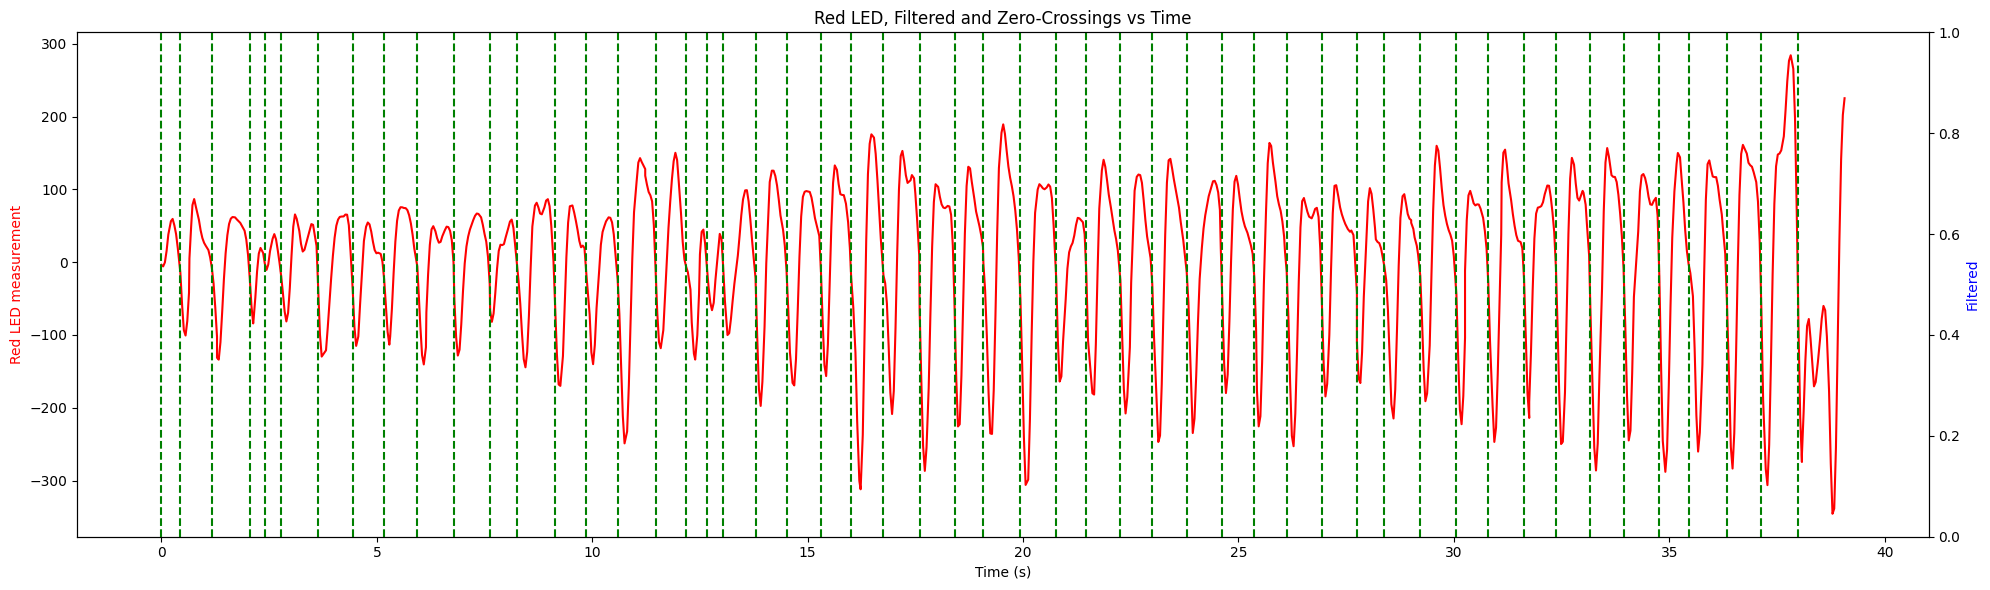

In [463]:
# Skip initial samples and start just after first zero crossing
# t = processed_data["Time (s)"]
# hr_data = processed_data["Red LED ADC"]
# cpp_filtered = processed_data["Filtered"]
# zero_cross = processed_data["ZeroCross"]

# Skip initial samples and start just after first zero crossing
initial_skip = 150
first_zero_cross_relative = np.argmax(processed_data["ZeroCross"][initial_skip:] != 0)
first_zero_cross_index = initial_skip + first_zero_cross_relative
# print(f"First zero crossing at index {first_zero_cross}")

# Extract time values and reset index
t = processed_data["Time (s)"][first_zero_cross_index:].reset_index(drop=True)
t = t - t.iloc[0]  # Ensure time starts at 0
cpp_filtered = processed_data["Filtered"][first_zero_cross_index:].reset_index(drop=True)
py_filtered = py_filtered_all[first_zero_cross_index:]
zero_cross = processed_data["ZeroCross"][first_zero_cross_index:].reset_index(drop=True)

# Test code
TEST_WITH_FIXED_SIGNAL = False

if TEST_WITH_FIXED_SIGNAL:
    # Generate the sinusoidal test signal to replace py_filtered for testing
    test_freq_hz = 1.6
    py_filtered = np.sin(2 * np.pi * test_freq_hz * t)
    # Generate zero crossings for the test signal only for negative crossings
    zero_cross = np.zeros(len(t))
    for i in range(1, len(t)):
        if py_filtered[i] < 0 and py_filtered[i - 1] >= 0:
            zero_cross[i] = 1

    # zero_cross = np.zeros_like(py_filtered)
    # zero_cross[0] = 1
    # for i in range(1, len(py_filtered)):
    #     if py_filtered[i] * py_filtered[i - 1] < 0:
    #         zero_cross[i] = 1

# Plot the original and filtered signals
plot_start = 0
plot_end = 2000

# Plot Red ADC, filtered and zero crossing points on different Y axes
fig, ax1 = plt.subplots(figsize=(20, 6))
ax2 = ax1.twinx()
ax1.plot(t[plot_start:plot_end], py_filtered[plot_start:plot_end], label="PyFiltered", color='red')

first_line = True
for tim, zc in zip(t[plot_start:plot_end], zero_cross[plot_start:plot_end]):
    if zc != 0:
        ax2.axvline(x=tim, color='green', linestyle='--', label="ZeroCross" if first_line else "")
        first_line = False

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Red LED measurement", color='red')
ax2.set_ylabel("Filtered", color='blue')
ax1.set_title("Red LED, Filtered and Zero-Crossings vs Time")
plt.tight_layout()
plt.show()

# # Plot the original and filtered signals
# plt.figure(figsize=(20, 6))
# plt.subplot(2, 1, 1)
# plt.plot(t[plot_start:plot_end], hr_data[plot_start:plot_end], label='Original Signal')
# plt.title('Original Heart Rate Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(t[plot_start:plot_end], filtered_hr_data[plot_start:plot_end], label='Filtered Signal', color='orange')
# plt.title('Filtered Heart Rate Signal (0.8 Hz to 3.25 Hz)')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()





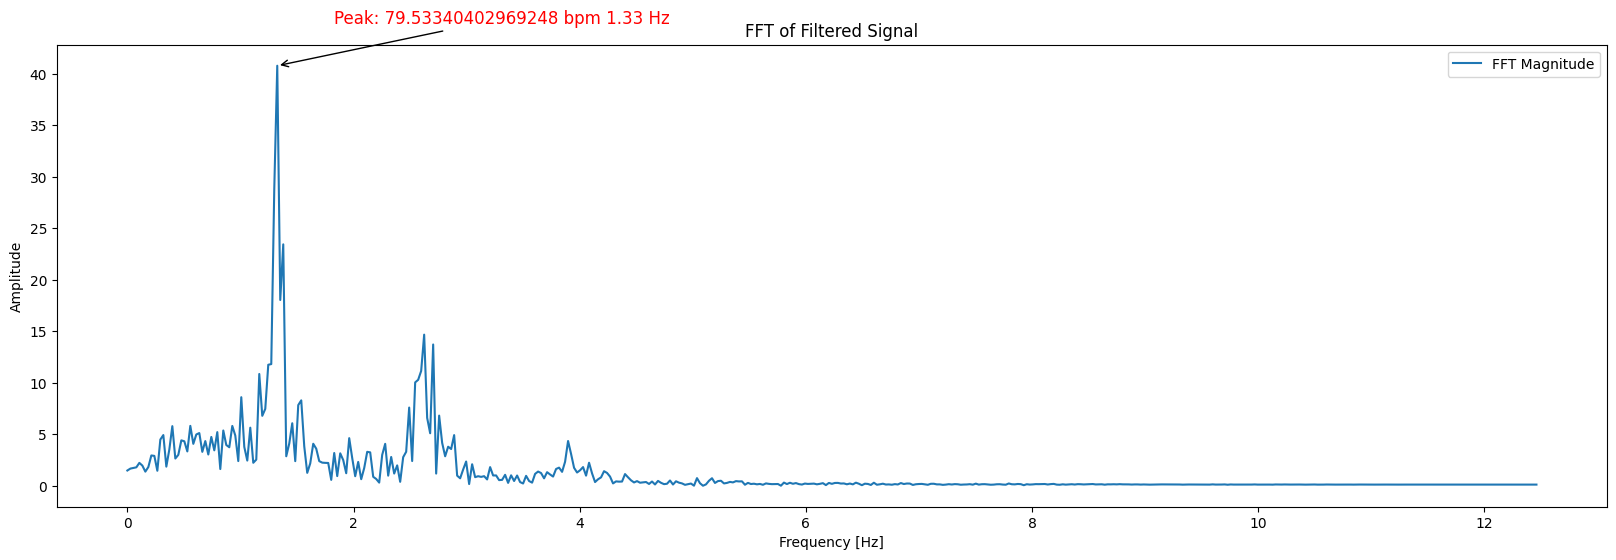

In [464]:
subset_data = py_filtered[plot_start:plot_end]
n = len(subset_data)
f = np.linspace(0, fs, n, endpoint=False)  # Frequency axis
Y = np.fft.fft(subset_data)

# Compute amplitude spectrum
amplitude_spectrum = np.abs(Y)[:n//2] * 1/n

# Find the peak frequency and amplitude
peak_index = np.argmax(amplitude_spectrum)
peak_freq = f[peak_index]
peak_amplitude = amplitude_spectrum[peak_index]

# Plot the FFT of the filtered signal
plt.figure(figsize=(20, 6))
plt.plot(f[:n//2], amplitude_spectrum, label="FFT Magnitude")
plt.title('FFT of Filtered Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# Annotate the peak
plt.annotate(f'Peak: {peak_freq*60.0} bpm {peak_freq:.2f} Hz', 
             xy=(peak_freq, peak_amplitude), 
             xytext=(peak_freq + fs * 0.02, peak_amplitude * 1.1),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=12, color='red')

plt.legend()
plt.show()

In [465]:
class PIDController:
    def __init__(self, kp: float, ki: float, kd: float, max_output: float, min_output: float):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.max_output = max_output
        self.min_output = min_output
        self.integral = 0.0
        self.last_error = 0.0

    def process(self, set_point: float, process_variable: float, time_delta_ms: int) -> float:
        # Ensure time delta is valid
        if time_delta_ms <= 0:
            return 0.0

        # Calculate time in seconds
        time_delta_secs = max(time_delta_ms / 1000.0, 0.001)  # Minimum 1ms to prevent instability

        # Calculate error
        error = set_point - process_variable

        # Proportional term
        p_out = self.kp * error

        # Integral term with anti-windup
        self.integral += error * time_delta_secs
        if self.ki != 0:
            self.integral = np.clip(self.integral, self.min_output / self.ki, self.max_output / self.ki)
        i_out = self.ki * self.integral

        # Derivative term
        derivative = (error - self.last_error) / time_delta_secs if time_delta_secs > 0 else 0
        d_out = self.kd * derivative

        # Compute total output
        output = p_out + i_out + d_out

        # Clamp output within limits
        output = np.clip(output, self.min_output, self.max_output)

        # Save error for next iteration
        self.last_error = error

        return output


In [466]:
class PhaseLockedLoop:
    def __init__(self, min_freq_hz: float, max_freq_hz: float, centre_freq_hz: float,
                 max_pid_output: float, kP: float, kI: float, kD: float):
        self._frequency_pid = PIDController(kP, kI, kD, max_pid_output, -max_pid_output)
        if min_freq_hz <= 0:
            min_freq_hz = 0.1
        if max_freq_hz <= min_freq_hz:
            max_freq_hz = min_freq_hz + 10
        self._max_freq_hz = max_freq_hz
        self._min_freq_hz = min_freq_hz
        if centre_freq_hz < min_freq_hz or centre_freq_hz > max_freq_hz:
            centre_freq_hz = (min_freq_hz + max_freq_hz) / 2
        self._centre_freq_hz = centre_freq_hz
        self._beat_freq_hz = centre_freq_hz  # Initial synthesized frequency
        self._last_pid_output = 0.0
        
        self._zero_crossing_first_ms = None  # First detected zero crossing
        self._last_zero_crossing_ms = None  # Last detected zero crossing
        self._expected_zero_crossing_ms = None  # Expected zero crossing based on PLL output

    def process_zero_crossing(self, sample_time_ms: int):
        if self._zero_crossing_first_ms is None:
            self._zero_crossing_first_ms = sample_time_ms
            self._last_zero_crossing_ms = sample_time_ms
            self._expected_zero_crossing_ms = sample_time_ms + 1000.0 / self._beat_freq_hz
            print(f"First zero crossing at {sample_time_ms}ms next zero crossing at {self._expected_zero_crossing_ms}ms")
            return

        if self._last_zero_crossing_ms is not None and sample_time_ms <= self._last_zero_crossing_ms + 1:
            return

        # Compute phase error (difference between actual and expected zero crossing)
        phase_error_ms = sample_time_ms - self._expected_zero_crossing_ms

        # Save last actual zero crossing time
        self._last_zero_crossing_ms = sample_time_ms

        # Compute PID output based on phase error
        self._last_pid_output = self._frequency_pid.process(0, phase_error_ms, sample_time_ms)

        # Adjust synthesized frequency based on PID output
        self._beat_freq_hz += self._last_pid_output
        self._beat_freq_hz = np.clip(self._beat_freq_hz, self._min_freq_hz, self._max_freq_hz)

        print(f"Phase err {phase_error_ms}ms at {sample_time_ms}ms (expected {self._expected_zero_crossing_ms}ms) last PID output {self._last_pid_output} freq {self._beat_freq_hz}Hz interval {1000.0 / self._beat_freq_hz}ms next zero crossing at {sample_time_ms + 1000.0 / self._beat_freq_hz}ms")

        # Update expected zero crossing time based on new beat frequency
        interval_ms = 1000.0 / self._beat_freq_hz
        self._expected_zero_crossing_ms = sample_time_ms + interval_ms

    def time_to_next_peak_ms(self, cur_time_ms: int) -> int:
        if self._beat_freq_hz <= 0:
            return 0

        # Interval in ms between zero crossings
        interval_ms = int(1000 / self._beat_freq_hz)

        if self._last_zero_crossing_ms is None:
            return interval_ms  # Default to full interval if no crossings recorded

        # Time since last zero crossing
        time_since_last_zero_ms = cur_time_ms - self._last_zero_crossing_ms

        # Time to next zero crossing
        time_to_next_zero_ms = interval_ms - time_since_last_zero_ms

        # Time to next peak is assumed to be quarter of the interval
        time_to_next_peak_ms = (time_to_next_zero_ms + (3 * interval_ms // 4)) % interval_ms
        return time_to_next_peak_ms

    def get_beat_freq_hz(self) -> float:
        return self._beat_freq_hz

    def get_coeffs(self):
        return self._frequency_pid.kp, self._frequency_pid.ki, self._frequency_pid.kd

    def get_last_pid_output(self):
        return self._last_pid_output

    def get_last_error(self):
        return self._frequency_pid.last_error



First zero crossing at 0ms next zero crossing at 1000.0ms
Phase err -560.0ms at 440ms (expected 1000.0ms) last PID output 0.3448683636363637 freq 1.3448683636363636Hz interval 743.5671973843739ms next zero crossing at 1183.567197384374ms
Phase err -13.567197384373912ms at 1170ms (expected 1183.567197384374ms) last PID output -0.01525686237472241 freq 1.3296115012616412Hz interval 752.0993907251257ms next zero crossing at 1922.0993907251257ms
Phase err 127.90060927487434ms at 2050ms (expected 1922.0993907251257ms) last PID output -0.06740035208656821 freq 1.262211149175073Hz interval 792.2604713589775ms next zero crossing at 2842.2604713589776ms
Phase err -442.2604713589776ms at 2400ms (expected 2842.2604713589776ms) last PID output 0.23831610404196624 freq 1.5005272532170393Hz interval 666.4324142437672ms next zero crossing at 3066.432414243767ms
Phase err -286.4324142437672ms at 2780ms (expected 3066.432414243767ms) last PID output 0.14970246729805525 freq 1.6502297205150946Hz interva

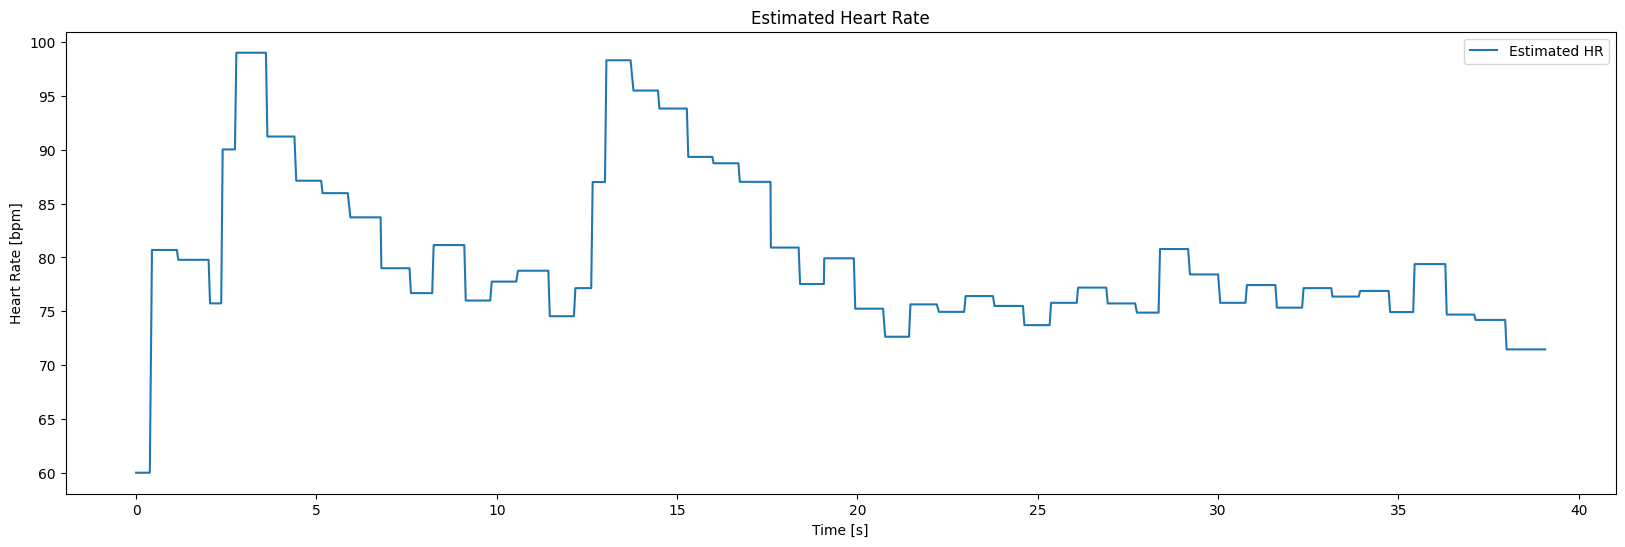

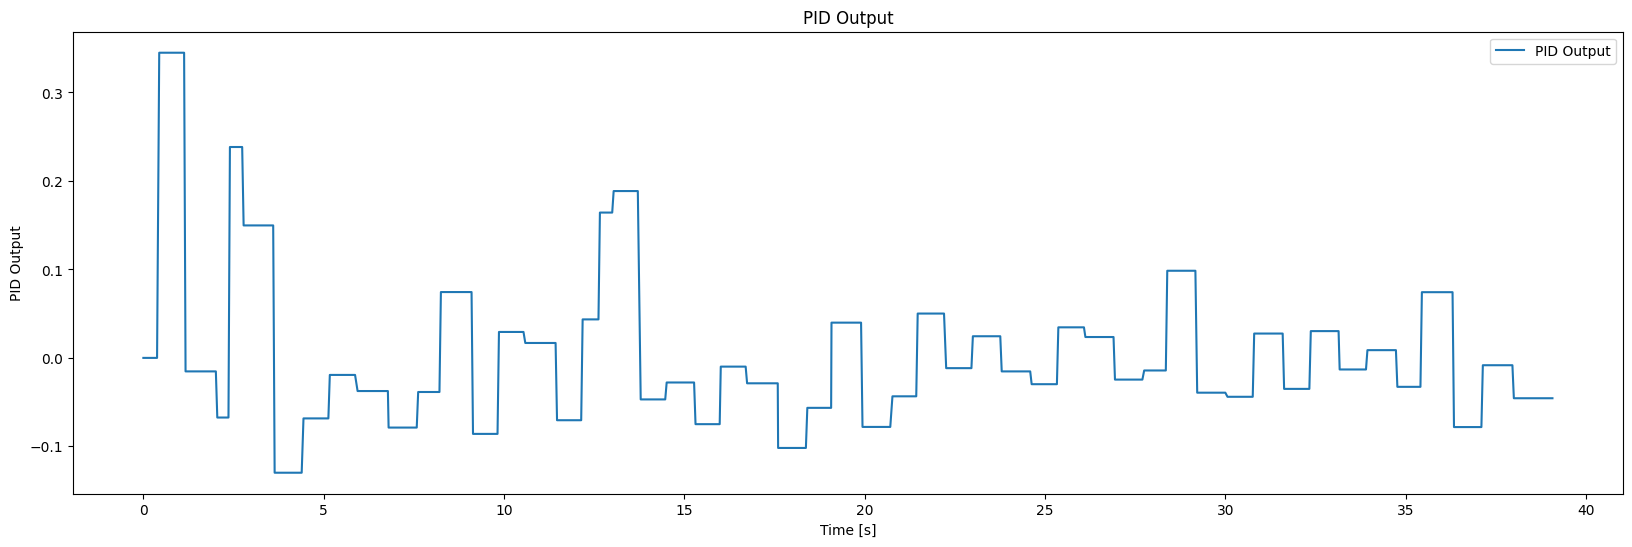

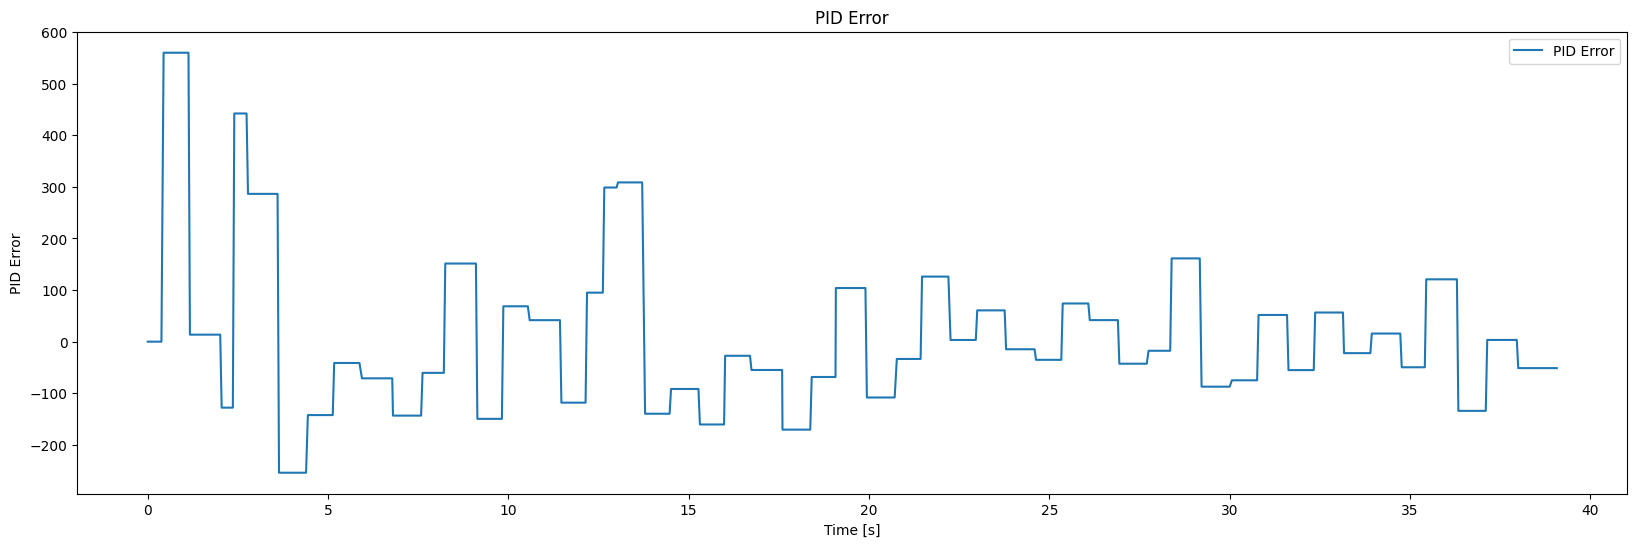

In [467]:
pll = PhaseLockedLoop(0.75, 3.0, 1, 10.0, 0.0005, 0.000005, 0.00005)
zero_cross_indices = np.where(zero_cross != 0)[0]
bpm = []
pid_output = []
pid_error = []
for i in range(plot_start, plot_end):
# for i in range(len(t)):
    if i >= len(t):
        break
    if zero_cross[i] != 0:
        timeMs = int(t[i] * 1000)
        pll.process_zero_crossing(timeMs)
    bpm.append(pll.get_beat_freq_hz() * 60.0)
    pid_output.append(pll.get_last_pid_output())
    pid_error.append(pll.get_last_error())

# Plot the estimated heart rate
plt.figure(figsize=(20, 6))
plt.plot(t[plot_start:plot_end], bpm, label='Estimated HR')
plt.title('Estimated Heart Rate')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')
plt.legend()
plt.show()

# Plot the PID output
plt.figure(figsize=(20, 6))
plt.plot(t[plot_start:plot_end], pid_output, label='PID Output')
plt.title('PID Output')
plt.xlabel('Time [s]')
plt.ylabel('PID Output')
plt.legend()
plt.show()

# Plot the PID error
plt.figure(figsize=(20, 6))
plt.plot(t[plot_start:plot_end], pid_error, label='PID Error')
plt.title('PID Error')
plt.xlabel('Time [s]')
plt.ylabel('PID Error')
plt.legend()
plt.show()

